# Streambed seepage model of river by Teichert and Rooney
The goal of this MODFLOW model is to apply detailed field data collected over two years to a diffusive wave streamflow routing package. Due to the location of this study, the regional groundwater table is well below the stream (60-80ft) such that the bottom of the model will be modeled as a seepage face. The diffusive wave model will be applied to calibrate the streambed hydraulic conductivities to match the stream stage and floodwave front velocities.

## Email from Margaret Shanafield
Hi Andrew,

Great to hear all is well for you.  I was thinking of emailing to see how it’s going.  Good idea to start in SFR; that way you can make sure your MODFLOW model works and all your segments and reaches are properly connected.  Having the water table that far below the surface makes things pretty easy; the water essentially just disappears from your streambed into the aquifer.  **If you think that the aquifer heterogeneity has a strong impact on where water infiltrates through the streambed, then go for it with your geostatistical model**.  But unless you are seeing big variation in the very shallow aquifer, I’m not sure how much difference it will make.  I’d suggest doing a dummy model with a homogeneous aquifer and then with an iteration of your geostatistical model and see whether there is any difference before you get too complicated with it.

 

Yes, it’s fine if your downstream elevation is higher; the diffusion wave is fine with that because unlike the kinematic wave formulation in SFR, all segments are solved simultaneously within the matrix.  How much higher are you thinking?  And what is your longitudinal discretization?  Remember that when you assign the thalweg elevation, it applies to the whole reach, whereas in the real world the elevation can change every metre (or less!). **If you have big steps between your reaches, it becomes difficult for the model to solve (water will back up and then the solution gets ugly…), and I think you’ll be sad;  this is the case for any model!** Also, if you have a lot of water backing up, you get estuarine conditions, and then you’d want to add some terms into the code to move it from diffusion wave approximation to full dynamic wave.  This also isn’t super difficult, though you’d want some assistance from Rich Niswonger, who is much closer and a coding guru.

 

UCODE should be fine- Saskia calibrated her model with PEST and that worked pretty well.

 

**Depression storage is a challenge.  Rich and I have talked a lot about it.  At one point we were planning to add it into the code, but we never did.  Depending on how good you are with coding in fortran, you could probably add this in!  Alternatively, I would suggest calculating your depression storage, and perhaps just adjusting your thalweg elevation to account for that volume within the reach.  This is what I have done with recent models.**  

Let me know whether that answers all your questions…

Margaret

Hi Andrew,

Okay, great.  I’ve just sent you all the source files- I recommend compiling them together instead of trying to mix and match with other version, otherwise you’ll have headaches. I use the Intel Fortran compiler, for reference (although the old Compaq one is what I used when writing the code and I loved that compiler). Like I said, Rich is not far from you and he’s amazing, so it might be worth looking at the code with him if you want to add storage and/or acceleration term. 
 
So wait, are you saying that as you move downstream, your streambed elevation suddenly jumps upward almost 5 m within a 10 m reach?  That’s like a wall!  Even an upward jump of a few meters over 50 meters is a very steep negative gradient, and I think you’d definitely want to add in the acceleration term, as that would create significant backwater effects.  Actually, unless your river is massive, a 5 m jump would create such a barrier that water would rarely flow beyond the reach.  Probably I am misunderstanding- if your stream is losing elevation over those reaches, that is no problem I think, although it might make for difficulties with cell size **(what is your river width?  You want to fit the river width into one cell, really, so that will help determine your cell size.**  Also remember that you don’t want a model that runs in real time).  I am used to slopes more on the order of 0.001 or lower; the diffusion wave is for mild slopes. 

I recommend starting with 20 m long reaches, or even longer; I think below that you’ll be overfitting, as the input parameters for the geometry are not so sophisticated as to capture every bump.  My colleague Saskia Noorduijn and I spent a long time building a model of the Woodforde River in central Australia, using LiDAR data.  If you haven’t yet extracted the geometry from your imagery, let me know and I’ll put you in touch with Saskia, who did this in a relatively sophisticated and automated way.  I’m sure she’d be happy to share, and to let you know potential pitfalls!

Start simple- you can always add in complexity, but you want a model that runs.

Regards,

In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [3]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Stream_seepage/'
lvl_dir = proj_dir+'Stream_level_data/'

In [4]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\Anaconda3\\envs\\geosp\\lib\\site-packages\\flopy\\__init__.py'>

# Time discretization
Streambed stage data was collected from December 2019 to December 2021 and successfully captured the first winter flows for both WY2020 and WY2021.

In [5]:

# Transient -> might want to think about making SP1 steady
end_date = '2020-09-30'
# end_date = '2018-01-02'
strt_date = '2019-10-01'

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)*np.append(np.ones(1),6*np.ones(nper-1))

# Grid discretization
The stream stage sensors are installed roughly every 500m in the stream channel, a discretization of 100m is the minimum in the transverse direction of the stream channel or else the stream will fill more space than just one model cell.

In [6]:
delr=100
delc=100
rotation=52.9

# model will only be in upper 0-70 ft of the domain, most likely only 0-30ft
unsat_thick = 20 # 20 meter depth roughly
thick = 5
nlay = int(unsat_thick/thick)

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [7]:
# load approximate extent of child model
# child_extent = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/child_model_extent/streambed_seepage_child_model_extent.shp')
# load parent model grid
parent_grid = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# join desired child domain extent to parent grid
# child_grid_parent_id = gpd.overlay(child_extent,parent_grid)
# create model domain that fits grid
# m_domain = child_grid_parent_id.dissolve(by='id')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
os.listdir(gwfm_dir+'/Mapping')
rm = pd.read_csv(gwfm_dir+'/Mapping/allsensor_latlong.csv')
rm = rm[rm.Group=='River']
rm_gdf = gpd.GeoDataFrame(rm, geometry = gpd.points_from_xy(rm.Longitude, rm.Latitude))
rm_gdf.crs='epsg:4326'
rm_gdf = rm_gdf.to_crs('epsg:32610')
rm_gdf = rm_gdf[rm_gdf.Site_id.str.contains('RM')]
rm_gdf = rm_gdf


In [9]:
rm_grid = gpd.sjoin(rm_gdf, parent_grid)
beg_row, beg_col = rm_grid.min()[['row','column']]-1
end_row, end_col = rm_grid.max()[['row','column']]+1

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:

beg_lay = 0
end_lay = 1

child_grid = parent_grid.loc[(parent_grid.row>=beg_row)&(parent_grid.row<end_row)]
child_grid = child_grid.loc[(child_grid.column>=beg_col)&(child_grid.column<end_col)]

child_grid = child_grid.rename({'node':'p_node','row':'p_row','column':'p_column'},axis=1)

In [11]:
child_grid['id'] = 0
m_domain = child_grid.dissolve('id')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geoseries.py:207: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


<AxesSubplot:>

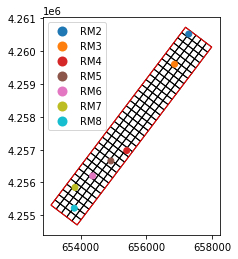

In [12]:
fig,ax=plt.subplots()
# child_extent.plot(ax=ax,color="None")
child_grid.plot(ax=ax, color="None")
m_domain.plot(color="none",edgecolor='red',ax=ax)
rm_gdf.plot('Site_id',legend=True,ax=ax)

In [13]:
scale = 2
ncol = 2*(child_grid.p_column.max() - child_grid.p_column.min())
nrow = 2*(child_grid.p_row.max() - child_grid.p_row.min())

In [14]:
coords = list(m_domain.geometry.values[0].exterior.coords)
xul = np.min(coords)
yul = coords[np.where(coords==xul)[0][0]][1]

In [15]:
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/'
model_ws = loadpth+'streambed_seepage'

In [16]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mfowhm', 
                          version = 'mfnwt', model_ws=model_ws)

#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [17]:
mg = m.modelgrid
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(653729.0099686472, 4254827.170999368) (653090.942825587, 4255309.737389564) (657072.1155447059, 4260573.79131981) (657710.182687766, 4260091.224929614)


In [18]:
# write modelgrid to get updated row and col numbers specific to the child grid
# m.modelgrid.write_shapefile(gwfm_dir+'/DIS_data/streambed_seepage/grid/rm_only_grid.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/grid/rm_only_grid.shp')
grid_p.crs = 'epsg:32610'

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

In [ ]:
# find matching based on current grid
# child_parent_match = gpd.sjoin(child_grid_parent_id, grid_p, op = 'within', how = 'right', lsuffix = '_P',rsuffix='_C')

Top of child grid needs to coincide with the top of the parent grid if vertical grid refinement is applied
It would be interesting to look at including the transfer of flow between the parent and child model as it is not currently implemented in MODFLOW. Need to create relation between parent and child grid row, column numbers

In [ ]:
from flopy.utils import Raster
# Full size dem of northern sac valley
raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/transformed.tif"

rio10_utm = Raster.load(raster_name)

# Nearest neighbor determines the nearest pixel and assumes its value
# linear is as it sounds, cubic is the smoothed version of linear essentially by using a cubic function
# the linear method takes a very, very long time - an hour plus??, just stick with nearest
# nearest takes 170.209 seconds - 220 seconds
# the linear interpolation causes the program to crash
t0 = time.time()
dem_data = rio10_utm.resample_to_grid(m.modelgrid,
                                band=rio10_utm.bands[0],
                                method="linear")
resample_time = time.time() - t0
print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

In [ ]:
np.savetxt(gwfm_dir+'\DIS_data\dem_52_9_rm_local_100m_linear.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_rm_local_100m_linear.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

# SFR

In [ ]:
sfr_dir = gwfm_dir+'/SFR_data/'